In [2]:
import torch
from torch import nn
from rbi.utils.autograd_tools import batch_jacobian

from functools import partial
import matplotlib.pyplot as plt

In [58]:
class ConditionalNeuralNet(nn.Module):
    def __init__(self, input_dim , context_dim, output_dim, hidden_dim=50):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_dim+context_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim,hidden_dim), nn.ReLU(), nn.Linear(hidden_dim,output_dim))

    def forward(self, x, context):
        input = torch.hstack([x, context])
        return self.net(input)

In [194]:
net = ConditionalNeuralNet(1,1,1)

In [195]:
def save_activations(module, input, output):
    module._activations = output.clone().detach()

def save_jacobian_linear(module, input, output):
    module._jacobian = module.weight.clone().detach().repeat(input[0].size(0), 1,1)

def save_jacobian_relu(module,input, output):
    jac = torch.zeros_like(input[0])
    jac[input[0] > 0] = 1. 
    module._jacobian = torch.diag_embed(jac)

def gather_activations(net):
    activations = []
    for n,l in net.named_modules():
        if hasattr(l, "_activations"):
            activations.append(l._activations)
    return activations

def gather_jacobians(net):
    jacs = []
    for n,l in net.named_modules():
        if hasattr(l, "_jacobian"):
            jacs.append(l._jacobian)
    return jacs

def compute_jacobian(net):
    jacs = gather_jacobians(net)
    J = jacs[-1]
    for J_i in reversed(jacs[:-1]):
        J = torch.bmm(J, J_i)
    return J





for n,l in net.named_modules():
    if isinstance(l, nn.ReLU):
        l.register_forward_hook(save_activations)
        l.register_forward_hook(save_jacobian_relu)
    if isinstance(l, nn.Linear):
        l.register_forward_hook(save_jacobian_linear)

In [196]:
X = torch.rand(1000, 1)*4
context = torch.rand(1000, 1)*3
Y = X.abs()**context

In [197]:
_ = net(X,context)

In [198]:
jacs = compute_jacobian(net)

In [199]:
optim = torch.optim.Adam(net.parameters())
for i in range(1000):
    optim.zero_grad()
    y_pred = net(X, context)
    loss = torch.mean((Y-y_pred)**2)
    loss.backward()
    optim.step()
    print(loss.detach())

tensor(83.7346)
tensor(82.7145)
tensor(81.6884)
tensor(80.6653)
tensor(79.6434)
tensor(78.6237)
tensor(77.6054)
tensor(76.5908)
tensor(75.5850)
tensor(74.5912)
tensor(73.6535)
tensor(72.7867)
tensor(71.9591)
tensor(71.1569)
tensor(70.3613)
tensor(69.5700)
tensor(68.7817)
tensor(68.0007)
tensor(67.2245)
tensor(66.4463)
tensor(65.6665)
tensor(64.8858)
tensor(64.1071)
tensor(63.3353)
tensor(62.5665)
tensor(61.8017)
tensor(61.0516)
tensor(60.3076)
tensor(59.5629)
tensor(58.8167)
tensor(58.0696)
tensor(57.3223)
tensor(56.5759)
tensor(55.8312)
tensor(55.0890)
tensor(54.3504)
tensor(53.6168)
tensor(52.8891)
tensor(52.1687)
tensor(51.4574)
tensor(50.7572)
tensor(50.0711)
tensor(49.3973)
tensor(48.7357)
tensor(48.0892)
tensor(47.4606)
tensor(46.8514)
tensor(46.2621)
tensor(45.6936)
tensor(45.1465)
tensor(44.6219)
tensor(44.1206)
tensor(43.6434)
tensor(43.1915)
tensor(42.7655)
tensor(42.3656)
tensor(41.9910)
tensor(41.6410)
tensor(41.3163)
tensor(41.0166)
tensor(40.7404)
tensor(40.4864)
tensor(4

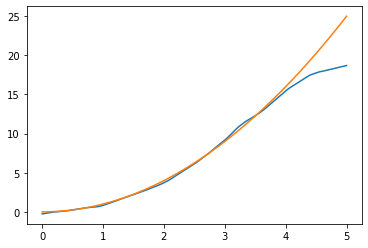

In [200]:
x = torch.linspace(0,5, 100).reshape(-1,1)
context = torch.ones(100,1)*2
plt.plot(x, net(x, context).detach())
plt.plot(x, x**context)

In [246]:
activations_over_context_domain_layer1 = []
activations_over_context_domain_layer2 = []
for i in torch.linspace(0,3, 100):
    net(torch.rand(100,1)*5, torch.ones(100,1)*i)
    activations = gather_activations(net)
    activations_over_context_domain_layer1.append(torch.mean((activations[0] > 0).float(), 0))
    activations_over_context_domain_layer2.append(torch.mean((activations[1] > 0).float(), 0))

In [247]:
activations_over_context_domain_layer1 = torch.vstack(activations_over_context_domain_layer1)
activations_over_context_domain_layer2 = torch.vstack(activations_over_context_domain_layer2)

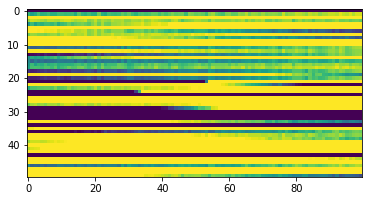

In [248]:
plt.imshow(activations_over_context_domain_layer1.T)

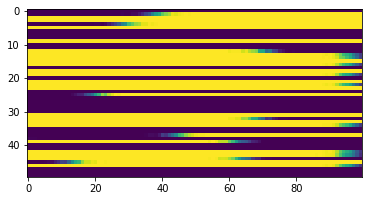

In [245]:
plt.imshow(activations_over_context_domain_layer2.T)

In [252]:
W1 = torch.randn(1,50)
W2 = torch.randn(50,50)
W3 = torch.randn(50, 1)


In [253]:
samples = []
for _ in range(100000):
    phi1 = torch.diag_embed(torch.randint(0,2,(50,)).float())
    phi2 = torch.diag_embed(torch.randint(0,2,(50,)).float())
    samples.append(W1@phi1@W2@phi2@W3)

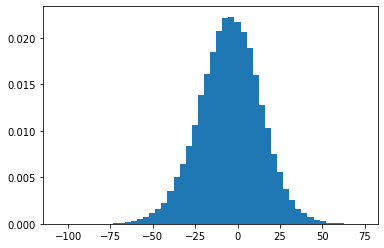

In [254]:
_ = plt.hist(torch.vstack(samples).numpy(), density=True, bins=50)

In [237]:
phi_dist = []
val_dist = []
for _ in range(100000):
    phi1 = torch.diag_embed(torch.randint(0,2,(50,)).float())
    phi2 = torch.diag_embed(torch.randint(0,2,(50,)).float())

    phi3 = torch.diag_embed(torch.randint(0,2,(50,)).float())
    phi4 = torch.diag_embed(torch.randint(0,2,(50,)).float())
    phi_dist.append(torch.trace((phi1-phi3)**2) + torch.trace((phi3-phi4)**2))
    val1 = (W1@phi1@W2@phi2@W3)
    val2 = (W1@phi3@W2@phi4@W3)
    val_dist.append((val1-val2)**2)



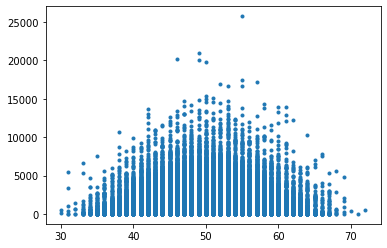

In [238]:
plt.plot(phi_dist, val_dist, ".")

In [4]:
def jacobian(net):
    jac = net[0]

Parameter containing:
tensor([[ 0.4065],
        [-0.7206],
        [ 0.8900],
        [ 0.1751],
        [ 0.1670],
        [ 0.6821],
        [-0.3528],
        [-0.0936],
        [-0.0036],
        [-0.9045]], requires_grad=True)